In [ ]:
!pip install --upgrade pip
!pip install --upgrade sagemaker awscli boto3 pandas

In [7]:
#For CPU
!conda install -y -c pytorch -c powerai pytorch torchtext torchvision

Solving environment: done

# All requested packages already installed.



In [ ]:
#For GPU
!conda install -y -c pytorch -c powerai pytorch torchtext torchvision cudatoolkit=10.1

In [16]:
!pip install --upgrade model-archiver

Requirement already up-to-date: model-archiver in /home/ec2-user/.anaconda3/envs/python36/lib/python3.6/site-packages (1.0.3)


In [ ]:
!conda remove -y torchserve torch-model-archiver

In [3]:
!conda install -y -c pytorch torchserve torch-model-archiver

Solving environment: done

## Package Plan ##

  environment location: /home/ec2-user/.anaconda3/envs/python36

  added / updated specs:
    - torch-model-archiver
    - torchserve


The following NEW packages will be INSTALLED:

  future             pkgs/main/linux-64::future-0.18.2-py36_0
  psutil             pkgs/main/linux-64::psutil-5.7.0-py36h7b6447c_0
  torch-model-archi~ pytorch/noarch::torch-model-archiver-0.0.1b20200409-py38_0
  torchserve         pytorch/noarch::torchserve-0.0.1b20200409-py38_0


Preparing transaction: done
Verifying transaction: done
Executing transaction: done


## Example: PyTorch deployments using TorchServe and Amazon SageMaker

In this example, we’ll show you how you can build a TorchServe container and host it using Amazon SageMaker. With Amazon SageMaker hosting you get a fully-managed hosting experience. Just specify the type of instance, and the maximum and minimum number desired, and SageMaker takes care of the rest.

With a few lines of code, you can ask Amazon SageMaker to launch the instances, download your model from Amazon S3 to your TorchServe container, and set up the secure HTTPS endpoint for your application. On the client side, get prediction with a simple API call to this secure endpoint backed by TorchServe.

Code, configuration files, Jupyter notebooks and Dockerfiles used in this example are available here:
https://github.com/shashankprasanna/torchserve-examples.git


### Clone the TorchServe repository and install torch-model-archiver

You'll use `torch-model-archiver` to create a model archive file (.mar). The .mar model archive file contains model checkpoints along with it’s `state_dict` (dictionary object that maps each layer to its parameter tensor).

In [11]:
!git clone https://github.com/pytorch/serve.git

Cloning into 'serve'...
remote: Enumerating objects: 74, done.
remote: Counting objects: 100% (74/74), done.
remote: Compressing objects: 100% (63/63), done.
remote: Total 6357 (delta 23), reused 35 (delta 4), pack-reused 6283
Receiving objects: 100% (6357/6357), 34.47 MiB | 69.49 MiB/s, done.
Resolving deltas: 100% (3325/3325), done.


### Download a PyTorch model and create a TorchServe archive

In [2]:
model_name = 'vgg19_bn' # densenet161

model_prefix = 'torchserve'
model_folder = f'./tmp/{model_prefix}_{model_name}'

!mkdir -p {model_folder}

model_pth = 'model.pth'
model_onnx = 'model.onnx'
model_mar = 'model.mar'
model_tar_gz = 'model.tar.gz'



In [3]:
import torch
from torchvision import datasets, models, transforms

model = getattr(models, model_name)(pretrained=True)

input_shape = [1, 3, 224, 224]
traced_model = torch.jit.trace(model.float().eval(), torch.zeros(input_shape).float())
# scripted_model = torch.jit.script(model.float().eval(), torch.zeros(input_shape).float())
traced_model.save(f"{model_folder}/{model_pth}")

In [15]:
!rm -f {model_folder}/{model_tar_gz} {model_folder}/{model_mar}
!torch-model-archiver --model-name model \
--version 1.0 --model-file model/{model_name}.py \
--serialized-file {model_folder}/{model_pth} \
--extra-files serve/examples/image_classifier/index_to_name.json \
--handler image_classifier

!tar cvfz {model_folder}/{model_tar_gz} {model_folder}/{model_mar}

usage: model-archiver [-h] --model-name MODEL_NAME --model-path MODEL_PATH
                      --handler HANDLER [--runtime {python,python2,python3}]
                      [--export-path EXPORT_PATH]
                      [--archive-format {tgz,no-archive,default}] [-f] [-c]
model-archiver: error: the following arguments are required: --model-path
tar: ./tmp/torchserve_vgg19_bn/model.mar: Cannot stat: No such file or directory
tar: Exiting with failure status due to previous errors


In [4]:
import tarfile

with tarfile.open(f"{model_folder}/{model_tar_gz}", 'w:gz') as f:
    f.add(f"{model_folder}/{model_mar}")

### Upload the generated densenet161.mar archive file to Amazon S3
Create a compressed tar.gz file from the densenet161.mar file since Amazon SageMaker expects that models are in a tar.gz file. 
Uploads the model to your default Amazon SageMaker S3 bucket under the models directory

### Create a boto3 session and get specify a role with SageMaker access

### Set up the environment

In [ ]:
import sagemaker

role = sagemaker.get_execution_role()

In [5]:
%%time
import boto3
iam_resource = boto3.resource('iam')
account_id = iam_resource.CurrentUser().arn.split(':')[4]

iam_client = boto3.client('iam')
response = iam_client.list_roles(
    PathPrefix='/service-role/',
    MaxItems=123
)

role_name = None
for i in response['Roles']:
    if i['RoleName'].startswith('AmazonSageMaker-ExecutionRole-'):
        role_name = i['RoleName']

role = f"arn:aws:iam::{account_id}:role/service-role/{role_name}"

CPU times: user 178 ms, sys: 19.5 ms, total: 198 ms
Wall time: 1.12 s


In [6]:
import boto3
import sagemaker
from sagemaker.utils import name_from_base

sess = sagemaker.Session()
region = sess.boto_region_name
bucket = sess.default_bucket()

job_name = name_from_base('sagemaker-containers')
prefix = job_name+'/torchserve'

model_path = sess.upload_data(path=f"{model_folder}/{model_tar_gz}", key_prefix=prefix)

data_shape = '{"input0":[1,3,224,224]}'

### Create an Amazon ECR registry
Create a new docker container registry for your torchserve container images.

In [1]:
ecr_repository_name = f"{model_prefix}-{model_name}"

print(account_id)
print(region)
print(role)
print(bucket)
print(ecr_repository_name)

NameError: name 'model_prefix' is not defined

In [8]:
docker_file = "docker/Dockerfile.torchserve"
!pygmentize -l docker {docker_file}

FROM ubuntu:18.04

ENV PYTHONUNBUFFERED TRUE

RUN apt-get update && \
    DEBIAN_FRONTEND=noninteractive apt-get install --no-install-recommends -y \
    fakeroot \
    ca-certificates \
    dpkg-dev \
    g++ \
    python3-dev \
    openjdk-11-jdk \
    curl \
    vim \
    && rm -rf /var/lib/apt/lists/* \
    && cd /tmp \
    && curl -O https://bootstrap.pypa.io/get-pip.py \
    && python3 get-pip.py

RUN update-alternatives --install /usr/bin/python python /usr/bin/python3 1
RUN update-alternatives --install /usr/local/bin/pip pip /usr/local/bin/pip3 1

RUN pip install --no-cache-dir psutil \
                --no-cache-dir torch \
                --no-cache-dir torchvision
                
ADD serve serve
RUN pip install ../serve/

COPY dockerd-entrypoint.sh /usr/local/bin/dockerd-entrypoint.sh
RUN chmod +x /usr/local/bin/dockerd-entrypoint.sh

RUN mkdir -p /home/model-server/ && mkdir -p /home/model-server/tmp
COPY config.properties /home/model-server/config.properties

WORKDIR /ho

In [9]:
!pygmentize -l bash docker/build_and_push.sh

#!/usr/bin/env bash

# This script shows how to build the Docker image and push it to ECR to be ready for use
# by SageMaker.

# The argument to this script is the image name. This will be used as the image on the local
# machine and combined with the account and region to form the repository name for ECR.
image=$1
docker_file=$2

if [ "$image" == "" ]
then
    echo "Usage: $0 <image-name> [docker-file]"
    exit 1
fi

if [ "$docker_file" == "" ]
then
    docker_file="Dockerfile"
fi

# chmod +x decision_trees/train
# chmod +x decision_trees/serve

# Get the account number associated with the current IAM credentials
account=$(aws sts get-caller-identity --query Account --output text)

if [ $? -ne 0 ]
then
    exit 255
fi


# Get the region defined in the current configuration (default to us-west-2 if none defined)
region=$(aws configure get region)
region=${region:-us-west-2}

if [ ${region} == "cn-north-1" ]; then
    # ecr.cn-north-1.amazonaws.com.cn
    fullname="${account}.dkr.ecr.$

### Build a TorchServe Docker container and push it to Amazon ECR

In [10]:
# %%capture
!sh docker/build_and_push.sh {ecr_repository_name} {docker_file} #$account_id $region $ecr_repository_name

WARNING! Using --password via the CLI is insecure. Use --password-stdin.
WARNING! Your password will be stored unencrypted in /home/ec2-user/.docker/config.json.
Configure a credential helper to remove this warning. See
https://docs.docker.com/engine/reference/commandline/login/#credentials-store

Login Succeeded
Sending build context to Docker daemon  12.41GB
Step 1/16 : FROM ubuntu:18.04
 ---> c3c304cb4f22
Step 2/16 : ENV PYTHONUNBUFFERED TRUE
 ---> Using cache
 ---> 2d0299c299a6
Step 3/16 : RUN apt-get update &&     DEBIAN_FRONTEND=noninteractive apt-get install --no-install-recommends -y     fakeroot     ca-certificates     dpkg-dev     g++     python3-dev     openjdk-11-jdk     curl     vim     && rm -rf /var/lib/apt/lists/*     && cd /tmp     && curl -O https://bootstrap.pypa.io/get-pip.py     && python3 get-pip.py
 ---> Using cache
 ---> c7367ea18b09
Step 4/16 : RUN update-alternatives --install /usr/bin/python python /usr/bin/python3 1
 ---> Using cache
 ---> 634e927213ee
Step 

In [11]:
container_image_uri = f'{account_id}.dkr.ecr.{region}.amazonaws.com/{ecr_repository_name}:latest'
print(container_image_uri)

533025023261.dkr.ecr.us-west-2.amazonaws.com/sagemaker-containers/sagemaker-containers-2020-05-01-05-13-53-505/torchserve:latest


### Deploy endpoint and make prediction using Amazon SageMaker SDK

In [15]:
from sagemaker.model import Model
from sagemaker.predictor import RealTimePredictor

sm_model_name = f'{model_prefix}-{model_name}'.replace('_', '-')

model = Model(model_data=model_path, 
                 image=container_image_uri,
                 role=role,
                 predictor_cls=RealTimePredictor,
                 name=sm_model_name)

In [16]:
import time

endpoint_name = f'{model_prefix}-{model_name}-endpoint-'.replace('_', '-') \
                    + time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())

predictor = model.deploy(instance_type='ml.c5.large',
                            initial_instance_count=1,
                            endpoint_name=endpoint_name)

-------------!

#### Test the TorchServe hosted model

### Invoke the endpoint

Let's test with a cat image.

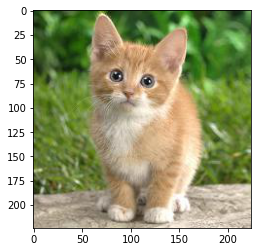

In [17]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

cat_img = 'image/cat1.jpg'
input_image = Image.open(cat_img)

plt.imshow(np.asarray(input_image))

In [18]:
import torch
from torchvision import transforms

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

In [19]:
%%time

import json

with open(cat_img, 'rb') as f:
    payload = f.read()

response = predictor.predict(data=payload)
print(*json.loads(response), sep = '\n')

{'Egyptian_cat': 0.5874680876731873}
{'tabby': 0.12313318997621536}
{'tiger_cat': 0.10180828720331192}
{'lynx': 0.03252970799803734}
{'red_fox': 0.023485548794269562}
CPU times: user 10.9 ms, sys: 1.13 ms, total: 12.1 ms
Wall time: 591 ms


### Deploy endpoint and make prediction using Python SDK (Boto3)

In [46]:
import boto3

boto_sm = boto3.client("sagemaker")

sm_model_name = 'torchserve-densenet161-boto'

container = {
    'Image': container_image_uri,
    'ModelDataUrl': model_path,
}

create_model_response = boto_sm.create_model(
                            ModelName         = sm_model_name,
                            ExecutionRoleArn  = role,
                            PrimaryContainer  = container
                        )

print(create_model_response['ModelArn'])

arn:aws:sagemaker:us-west-2:533025023261:model/torchserve-densenet161-boto


In [47]:
import time
endpoint_config_name = 'torchserve-endpoint-config-' + time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())
print(endpoint_config_name)

create_endpoint_config_response = boto_sm.create_endpoint_config(
    EndpointConfigName = endpoint_config_name,
    ProductionVariants = [{
        'InstanceType'        : 'ml.m4.xlarge',
        'InitialVariantWeight': 1,
        'InitialInstanceCount': 1,
        'ModelName'           : sm_model_name,
        'VariantName'         : 'AllTraffic'}])

print("Endpoint Config Arn: " + create_endpoint_config_response['EndpointConfigArn'])

torchserve-endpoint-config-2020-04-30-05-47-55
Endpoint Config Arn: arn:aws:sagemaker:us-west-2:533025023261:endpoint-config/torchserve-endpoint-config-2020-04-30-05-47-55


In [48]:
endpoint_name = 'torchserve-endpoint-' + time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())
print(endpoint_name)

create_endpoint_response = boto_sm.create_endpoint(
                                EndpointName         = endpoint_name,
                                EndpointConfigName   = endpoint_config_name
                            )
print(create_endpoint_response['EndpointArn'])

torchserve-endpoint-2020-04-30-05-48-14
arn:aws:sagemaker:us-west-2:533025023261:endpoint/torchserve-endpoint-2020-04-30-05-48-14


In [49]:
resp = boto_sm.describe_endpoint(EndpointName=endpoint_name)
status = resp['EndpointStatus']
print("Status: " + status)

while status=='Creating':
    time.sleep(60)
    resp = boto_sm.describe_endpoint(EndpointName=endpoint_name)
    status = resp['EndpointStatus']
    print("Status: " + status)

print("Arn: " + resp['EndpointArn'])
print("Status: " + status)

Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: InService
Arn: arn:aws:sagemaker:us-west-2:533025023261:endpoint/torchserve-endpoint-2020-04-30-05-48-14
Status: InService


In [53]:
import boto3

boto_smrt = boto3.client("sagemaker-runtime")

import json

with open(cat_img, 'rb') as f:
    payload = f.read()

response = boto_smrt.invoke_endpoint(EndpointName=endpoint_name, 
                                   ContentType='application/x-image', 
                                   Body=payload)

print(*json.loads(response['Body'].read()), sep = '\n')

{'tiger_cat': 0.4693359136581421}
{'tabby': 0.4633873701095581}
{'Egyptian_cat': 0.06456154584884644}
{'lynx': 0.001282821292988956}
{'plastic_bag': 0.00023323031200561672}
